In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [81]:
df = pd.read_csv('cleaned_ebay_deals.csv')

In [82]:
df.head()

,timestamp,title,price,original_price,shipping,url,discount_percentage
0,2025-03-19 06:28:22,"Klipsch R-120SWi 12"" High-Performance Wireless...",159.99,179.99,Free shipping,https://www.ebay.com/itm/365374754988?_trkparm...,11.11
1,2025-03-19 06:28:22,Apple iPhone 14 Pro Max 128GB Network Unlocked...,499.99,1099.00,Free shipping,https://www.ebay.com/itm/365374754988?_trkparm...,54.51
2,2025-03-19 06:28:22,Apple iPhone 14 Pro Max 256GB Unlocked Very Go...,549.99,1199.00,Free shipping,https://www.ebay.com/itm/365374754988?_trkparm...,54.13
3,2025-03-19 06:28:22,Apple iPhone 14 Pro A2650 128GB Network Unlock...,414.99,899.00,Free shipping,https://www.ebay.com/itm/365374754988?_trkparm...,53.84
4,2025-03-19 06:28:22,Apple iPhone 14 128GB Network Unlocked Very Go...,305.99,749.00,Free shipping,https://www.ebay.com/itm/365374754988?_trkparm...,59.15


In [83]:
df.isnull().sum()

,0
timestamp,0
title,0
price,0
original_price,0
shipping,0
url,0
discount_percentage,0


In [84]:
df = df.dropna(subset=["price", "original_price", "shipping", "discount_percentage"])

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3975 entries, 0 to 3974
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            3975 non-null   object 
 1   title                3975 non-null   object 
 2   price                3975 non-null   float64
 3   original_price       3975 non-null   float64
 4   shipping             3975 non-null   object 
 5   url                  3975 non-null   object 
 6   discount_percentage  3975 non-null   float64
dtypes: float64(3), object(4)
memory usage: 217.5+ KB


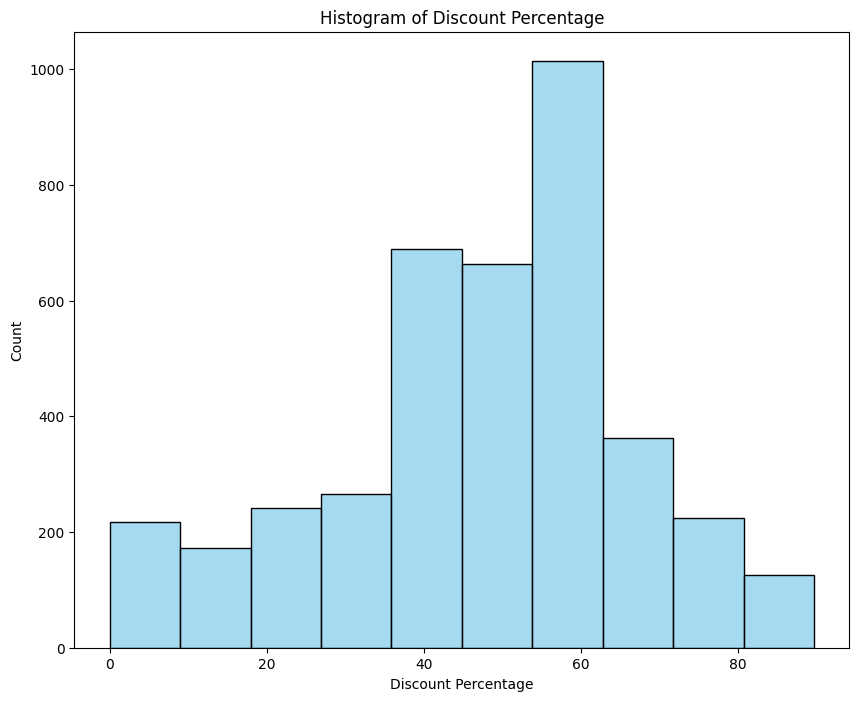

In [86]:
plt.figure(figsize=(10, 8))
sns.histplot(df['discount_percentage'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Discount Percentage')
plt.xlabel('Discount Percentage')
plt.show()



In [87]:
bins = [0, 10, 30, float('inf')]
labels = ['Low', 'Medium', 'High']

df['discount_bin'] = pd.cut(df['discount_percentage'], bins=bins, labels=labels, include_lowest=True)


df[['discount_percentage', 'discount_bin']].head(10)


,discount_percentage,discount_bin
0,11.11,Medium
1,54.51,High
2,54.13,High
3,53.84,High
4,59.15,High
5,54.46,High
6,47.46,High
7,49.22,High
8,53.50,High
9,62.38,High


In [88]:
category_counts = df['discount_bin'].value_counts()
print(category_counts)

discount_bin
High      3226
Medium     488
Low        261
Name: count, dtype: int64


In [89]:
df.shape

(3975, 8)

In [90]:
min_size = df['discount_bin'].value_counts().min()

low_df = df[df['discount_bin'] == 'Low']
medium_df = df[df['discount_bin'] == 'Medium'].sample(min_size, random_state=1)
high_df = df[df['discount_bin'] == 'High'].sample(min_size, random_state=1)

df_balanced = pd.concat([low_df, medium_df, high_df]).reset_index(drop=True)

print(df_balanced['discount_bin'].value_counts())



discount_bin
Low       261
Medium    261
High      261
Name: count, dtype: int64


In [91]:
#Drop bin column
df_balanced = df_balanced.drop(columns=['discount_bin'])

print(df_balanced.head())

             timestamp                                              title  \
0  2025-03-19 10:27:36  DS18 Car Speakers Package 4x Speakers 6.5" Mid...   
1  2025-03-19 10:28:01  Apple iPhone 14 256GB Network Unlocked Excelle...   
2  2025-03-19 10:28:04  Apple iPhone 12 Pro A2341 256GB Unlocked Good ...   
3  2025-03-19 10:28:08  Apple MacBook Pro 13" Late 2020 M1 1TB SSD 16G...   
4  2025-03-19 20:27:26  Seagate Exos 24TB SATA HDD ST24000NM000C 7.2K ...   

    price  original_price                   shipping  \
0  147.95          147.95  Shipping info unavailable   
1  412.49          426.21  Shipping info unavailable   
2  299.99          299.99  Shipping info unavailable   
3  649.99          649.99  Shipping info unavailable   
4  271.99          299.99              Free shipping   

                                                 url  discount_percentage  
0  https://www.ebay.com/itm/365374754988?_trkparm...                 0.00  
1  https://www.ebay.com/itm/365374754988?_trkpar

In [92]:

X = df_balanced[["price", "original_price", "shipping"]]
y = df_balanced["discount_percentage"]

enc = OneHotEncoder()

encoded_shipping = enc.fit_transform(X[['shipping']]).toarray()

encoded_shipping_df = pd.DataFrame(encoded_shipping)

X_encoded = pd.concat([X.drop('shipping', axis=1).reset_index(drop=True), encoded_shipping_df], axis=1)

print(X_encoded.head(10))



     price  original_price    0    1
0   147.95          147.95  0.0  1.0
1   412.49          426.21  0.0  1.0
2   299.99          299.99  0.0  1.0
3   649.99          649.99  0.0  1.0
4   271.99          299.99  1.0  0.0
5   299.99          299.99  1.0  0.0
6  1125.99         1125.99  0.0  1.0
7   402.50          426.21  0.0  1.0
8   649.99          649.99  0.0  1.0
9   402.50          426.21  0.0  1.0


In [93]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [94]:
model = LinearRegression()
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 11.393543401277364
Mean Squared Error (MSE): 229.22694523724041
Root Mean Squared Error (RMSE): 15.140242575244308
R-squared (R²): 0.5849860173014556


In [95]:
#MAE: MAE measures the average magnitude of the errors in a set of predictions,without considering their direction (whether the predictions are above or below the actual values).
  #It represents the average absolute difference between the predicted values (y_pred) and the actual values (y_true).
  #11.39 is relatively large error, suggesting that the model's predictions might not be very accurate in general.

In [96]:
#Mean Squared Error (MSE): 229.23
  #MSE measures the average of the squared differences between the actual and predicted values. Since it squares the errors, it gives more weight to larger errors, making it more sensitive to outliers.
  #The MSE value of 229.23 suggests that, on average, the squared differences between the actual and predicted discount_percentage are relatively large.
  #This is another indication that the model might be overestimating or underestimating the discount_percentage by significant amounts

In [97]:
#Root Mean Squared Error (RMSE): 15.14
  #RMSE is the square root of MSE. It brings the error back to the original units of the target variable, making it easier to interpret compared to MSE.
  #The RMSE value of 15.14 means that, on average, the model's predictions are off by approximately 15.14 percentage points.
  #This is a relatively large error, again indicating that the model may not be accurately predicting the discount_percentage across the data.

In [98]:
#R-squared (R²): 0.585
  #It measures how well the independent variables (features) explain the variability in the target variable.
  #It compares the sum of squared errors from your model to the total sum of squared errors from a baseline model that always predicts the mean of the target variable.
  #about 58.5% of the variance in the discount_percentage is explained by the model.
  #This is a moderate value; it suggests that the model is capturing some of the patterns in the data, but there is still a significant portion of the variance (41.5%) that the model is not able to explain.

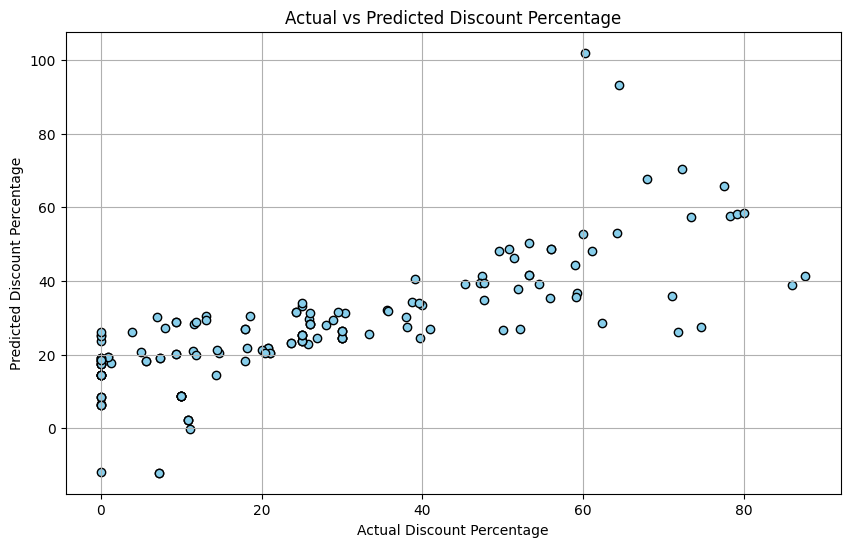

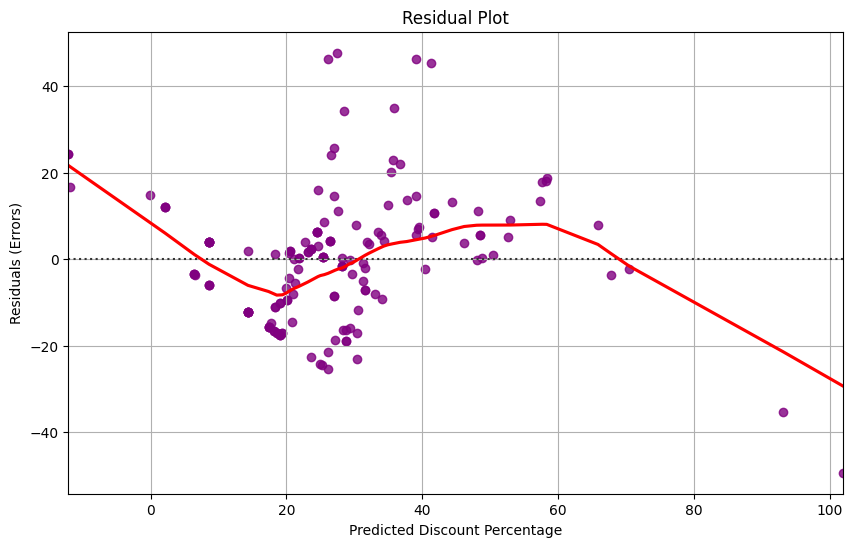

In [99]:
# 1. Scatter Plot of Actual vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='skyblue', edgecolor='black')
plt.title('Actual vs Predicted Discount Percentage')
plt.xlabel('Actual Discount Percentage')
plt.ylabel('Predicted Discount Percentage')
plt.grid(True)
plt.show()

# 2. Residual Plot (Actual - Predicted)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='purple', line_kws={'color': 'red'})
plt.title('Residual Plot')
plt.xlabel('Predicted Discount Percentage')
plt.ylabel('Residuals (Errors)')
plt.grid(True)
plt.show()


In [100]:
# Applying the Model to Incomplete Data

df_without_discount = df_balanced.drop(columns=['discount_percentage'])
print(df_without_discount.head())


             timestamp                                              title  \
0  2025-03-19 10:27:36  DS18 Car Speakers Package 4x Speakers 6.5" Mid...   
1  2025-03-19 10:28:01  Apple iPhone 14 256GB Network Unlocked Excelle...   
2  2025-03-19 10:28:04  Apple iPhone 12 Pro A2341 256GB Unlocked Good ...   
3  2025-03-19 10:28:08  Apple MacBook Pro 13" Late 2020 M1 1TB SSD 16G...   
4  2025-03-19 20:27:26  Seagate Exos 24TB SATA HDD ST24000NM000C 7.2K ...   

    price  original_price                   shipping  \
0  147.95          147.95  Shipping info unavailable   
1  412.49          426.21  Shipping info unavailable   
2  299.99          299.99  Shipping info unavailable   
3  649.99          649.99  Shipping info unavailable   
4  271.99          299.99              Free shipping   

                                                 url  
0  https://www.ebay.com/itm/365374754988?_trkparm...  
1  https://www.ebay.com/itm/365374754988?_trkparm...  
2  https://www.ebay.com/itm/3653747

In [101]:
# Randomly select 20 products and retain the specified columns
selected_columns = ['price', 'original_price', 'shipping', 'title']

# If 'title' is available in the dataset, it will be included
df_sample = df_without_discount[selected_columns].dropna().sample(n=20, random_state=1)

# Display the selected sample
print(df_sample)


       price  original_price                   shipping  \
703   402.00          649.95  Shipping info unavailable   
265  1999.00         2665.00              Free shipping   
111  1309.00         1309.00  Shipping info unavailable   
301  2809.00         3149.00  Shipping info unavailable   
339    89.00          112.82  Shipping info unavailable   
558   439.99          999.00              Free shipping   
638   479.99          999.00  Shipping info unavailable   
202  1799.99         1999.99  Shipping info unavailable   
546   167.99          279.99  Shipping info unavailable   
679  1057.00         1999.99  Shipping info unavailable   
223  1125.99         1125.99  Shipping info unavailable   
763   734.00         1799.00  Shipping info unavailable   
696   304.99          749.00              Free shipping   
233  1799.99         1999.99  Shipping info unavailable   
446  1219.99         1485.99  Shipping info unavailable   
19    397.15          426.21  Shipping info unavailable 

In [113]:

X_new = df_sample[["price", "original_price", "shipping"]]
predicted_discounts = model.predict(X_new)

# Add predictions to the sample
sample_df["Predicted Discount (%)"] = predicted_discounts.round(2)

# Reorder and display as a clean table
result_table = df_sample[["title", "price", "original_price", "shipping", "Predicted Discount (%)"]]

print("\nPredicted Discount Percentages for 20 Products:\n")
print(result_table.to_string(index=False))



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- shipping
Feature names seen at fit time, yet now missing:
- 0
- 1
